# How was the experience!?
Finally we have made our first steps into the generation field! There still is the ocean needs to be sailed, so hold on, don't fear, let's keep going.

So, as discussed in the previous notebook, we have ***counted*** the character bigrams manually, so that is something we will call the "trained" model and with that static info in mind, at hand, we have tried to generate the **new** names.

**Now**, we want to do the same - but we will use the neural net ***to learn those counts*** instead of providing the counts manually *(so a bit more towards deep "learning")*.

## The overview of the 🧠

    The input (like we did in previous) - a character 
        → Neural Net
            → Distribution after that character
                → Predict the next word

> **Hands up 👐**: Before moving on, ***this*** time and from now on, we will use the `torch` library for doing all stuff. Please don't hate me doing this, because we are now building the neural nets mate! That simply would be to verbose with the numpy.

So, for anything from random number generation to the neural net, we will use the torch. Whenever possible, I will provide the *"alternative"* code for the same in numpy, but for most of the part, we will use the torch. Sorry for that, because sooner or later we will need to use pytorch, because other libraries like Tensorflow are now the history and torch is the future *(to light in the darkness 😉)*. Argh [clears throat], pardon me.

*PS: Don't worry, we will use micrograd as well to see the comparison in learning between torch model and micrograd as bonus 🎉*

### As a sum-up of the situation

We have 2 ways to learn the relationships between the characters (to generate new ones)

<pre>
                                                                      
                                                                      
                                                                      
                                                                      
                   +-------------------+         +-------------------+
                   |                   |         |                   |
                   | Way 1             |         | Way 2             |
                   |                   |         |                   |
                   | Give a computer   |         | Let the computer  |
                   | the set of rules  |         | find the rules    |
                   | by finding them   |         | and use them for  |
                   | manually          |         | the generation.   |
                   |                   |         |                   |
                   +--------|----------+         +--------|----------+
                            |                             |           
                            |                             |           
                   +--------|----+                 +------|------+    
                   |             |                 |             |    
                   | The bigram  |                 |The bigram   |    
                   | table given |                 |table learnt |    
                   |             |                 |by NN        |    
                   +-------|-----+                 +-------|-----+    
                           |                               |          
                           |                               |          
                     Generate!                       Generate!        
                     💻: ...                         🤖: ...          
</pre>

Great, so now we are on the **way 2** and will learn the bigram table. *(of course, I am using the "bigram table to learn" phrase loosely. We don't learn the tables but the rules that generalize the relationship which infact are not in the form of the table, but the graph that spans across the millions, billions of parameters that the tables can never store.)*

In [4]:
# The usual imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## TORCH WILL BE IMPORTED LATER. LEGENDS HAVE THEIR OWN ENTERIES! ##

👉 As a refresher, here are our names.

In [5]:
# loading the dataset
with open("./names.txt", "r") as file:
    names = file.read().splitlines()

In [6]:
names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

If you are familiar with the "ARIMA" model, we basically ***make*** (again, ***make***) the dataset as a supervised learning dataset. These type of problems don't have the conventional labels to learn so we make them!

So, in this NLG setting, we will "predict" the next character here, thus, for the past word `ch1` the next token to be predicted will be `ch2` so that `ch2` will be the "label" for the `ch1`. Then `ch3` will be the label for the `ch2` and it will continue for all words in the universe.
___
Here, for our names...

In [7]:
# Our same loop will work!

for name in names[:5]:
    print("\n---", name, "---")
    name = "<" + name + ">"
    for ch1, ch2 in zip(name, name[1:]):    
        print(ch1, "→", ch2)


--- emma ---
< → e
e → m
m → m
m → a
a → >

--- olivia ---
< → o
o → l
l → i
i → v
v → i
i → a
a → >

--- ava ---
< → a
a → v
v → a
a → >

--- isabella ---
< → i
i → s
s → a
a → b
b → e
e → l
l → l
l → a
a → >

--- sophia ---
< → s
s → o
o → p
p → h
h → i
i → a
a → >


In [8]:
## MAKING THE DATASET ##

xs = [] # The ch1 (previous character)
ys = [] # The ch2 (next character to be predicted - lables)

for name in names:
    name = "<" + name + ">"
    for ch1, ch2 in zip(name, name[1:]):    
        xs.append(ch1)
        ys.append(ch2)

In [9]:
len(xs)

228146

In [10]:
len(ys)

228146

In [11]:
xs[:5]

['<', 'e', 'm', 'm', 'a']

In [12]:
ys[:5]

['e', 'm', 'm', 'a', '>']

Are you getting it mate!?

And, we will convert these into the tensors... because some famous pythonist once said:
> "Convert the data into the language that the NNs can understand, which are fast to operate through, <br>and lists are not the one of them." <br><br>— Unknown *(probably me)**

In [13]:
## for the CPU dependency ##
# !pip3 install torch torchvision torchaudio

In [14]:
# First time using the tensors
import torch

In [15]:
xs[:5]

['<', 'e', 'm', 'm', 'a']

In [16]:
xs = torch.tensor(xs)
ys = torch.tensor(ys)

ValueError: too many dimensions 'str'

# 🤯 Oops!
This has to happen. <br>
**Because tensors** only understand the numerical values. But we are passing the string. So, to convert these into the numbers, we need the *mapping*. 

Sorry me, in the previous example of Makemore (and to simplify the process) we did not do such conversion from string to number. But now, we will need to. So let's quickly do that.

In [17]:
# We will map `<` and `>` special tokens as 0 and 1, after that we will start with a, b, c...

## For safety, we will only use the characters which are present in the dataset ##
unique_characters = set()
for name in names:
    for ch in name:
        unique_characters.add(ch)

In [18]:
unique_characters = ['<', '>'] + sorted(list(unique_characters))
unique_characters

['<',
 '>',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

We cool?

In [19]:
number_to_ch = {}
ch_to_number = {}
for idx, ch in enumerate(unique_characters):
    number_to_ch[idx] = ch
    ch_to_number[ch] = idx

In [20]:
number_to_ch

{0: '<',
 1: '>',
 2: 'a',
 3: 'b',
 4: 'c',
 5: 'd',
 6: 'e',
 7: 'f',
 8: 'g',
 9: 'h',
 10: 'i',
 11: 'j',
 12: 'k',
 13: 'l',
 14: 'm',
 15: 'n',
 16: 'o',
 17: 'p',
 18: 'q',
 19: 'r',
 20: 's',
 21: 't',
 22: 'u',
 23: 'v',
 24: 'w',
 25: 'x',
 26: 'y',
 27: 'z'}

In [21]:
ch_to_number

{'<': 0,
 '>': 1,
 'a': 2,
 'b': 3,
 'c': 4,
 'd': 5,
 'e': 6,
 'f': 7,
 'g': 8,
 'h': 9,
 'i': 10,
 'j': 11,
 'k': 12,
 'l': 13,
 'm': 14,
 'n': 15,
 'o': 16,
 'p': 17,
 'q': 18,
 'r': 19,
 's': 20,
 't': 21,
 'u': 22,
 'v': 23,
 'w': 24,
 'x': 25,
 'y': 26,
 'z': 27}

In [22]:
### Now the dataset creation! ###

xs = [] # The ch1 (previous character)
ys = [] # The ch2 (next character to be predicted - lables)

for name in names[:1]: # looking at the first example name only
    name = "<" + name + ">"
    for ch1, ch2 in zip(name, name[1:]):    
        xs.append(ch_to_number[ch1])
        ys.append(ch_to_number[ch2])

In [23]:
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [24]:
name

'<emma>'

In [25]:
xs

tensor([ 0,  6, 14, 14,  2])

In [26]:
ys

tensor([ 6, 14, 14,  2,  1])

Here, we want the neural network to learn the weights that can assign the *highest* probability to the character `6` when the `0` comes the first, then assign `14` as the highest probability after the `6`.

*(Note: Since I have taken `<` and `>` both as the special tokens in my example, the encoded values of `a`, `b`, `c` ... are increased by +1 than shown in the actual video.)*

___
> ⚠ <br>The similar operation to `torch.tensor(...)` in numpy is `numpy.array(...)`
___

## 🔧 Building the Net
So, the data is ready with us *(at least for single name "emma" now)*. We now need to think through what the *structure* of the net should be.

Here we have the tensor like [0, 6, 14, 14, 2] which as a fixed length (here 5). So, should we straightly go forward with the net with input dimension 5? **No**. Because of the following reasons:
1. We **don't have** the "fixed" size names in whole dataset
2. We **are not** training the net to predict "emma>" when the "<emma" is given!

See the things emerging? We are training the net to predict the next character, and not a whole word. And to predict a whole word, we would have different and more robust technique there.

To tackle this problem, we will **again**, need to **convert** these numbers into some other encoding. Here we will use the `one-hot` encoding. Which is so popular in the standard "ML" problems in converting the string values into the numbers.

### 📏 Which has the same length!
How many total characters do we have? Total `28` *(0 to 27)*. So, if we encode each character into one-hot, then we will have a dense matrix encoded for each character.

For our "emma" example, we have...

    [
        0  → [1, 0, 0, 0, 0, 0, ...]
        6  → [0, 0, 0, 0, 0, 1, ...]
        14 → [0, 0, 0, 0, ... 1, 0, 0...]
        14 → [0, 0, 0, 0, ... 1, 0, 0...]
        2  → [0, 0, 1, 0, 0, 0, ...]
    ]

This will be clearer soon. Here we just have converted the indexes into their respective encoded values.

In [27]:
# in pytorch
encoded = torch.nn.functional.one_hot(xs)
encoded

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [28]:
encoded.shape

torch.Size([5, 15])

See that, it simply has the length of `15` and **not** the `28`. The reason is it **automatically** calculated the size from the input (here the largest index is `14`).

To solve this issue, we will use the `num_classes` attribute of the *one_hot* method.

In [29]:
# with `num_classes` attribute
encoded = torch.nn.functional.one_hot(xs, num_classes=28)
encoded

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [30]:
encoded.shape

torch.Size([5, 28])

In [31]:
encoded.dtype

torch.int64

#### Cool! 🥂
___

> ⚠ <br> Numpy ***doesn't directly support*** this type of one-hot conversion, but there are work arounds like using `np.identity()` and `np.zeros()` with leading operations. Checkout this [here](https://stackoverflow.com/questions/29831489/convert-array-of-indices-to-one-hot-encoded-array-in-numpy).
___

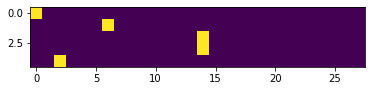

In [32]:
# Just to see how that looks...
plt.imshow(encoded)

### 😓 for some reason the kernel dies while plotting with plt, you may skip this cell it is harmless ###
### if you face the same issue with plt/sns use: conda install freetype=2.10.4

In [33]:
xs_encoded = encoded.float()

We needed to perform the "float conversion" because it gives much more variability in the learning process in the NN than "int".

## 🏋️‍♂️ Initializing the weights

In [34]:
generator = torch.Generator().manual_seed(42)

W = torch.randn((28, 1), generator=generator) # sampling from the standard normal distribution
W

tensor([[ 1.9269],
        [ 1.4873],
        [ 0.9007],
        [-2.1055],
        [ 0.6784],
        [-1.2345],
        [-0.0431],
        [-1.6047],
        [-0.7521],
        [ 1.6487],
        [-0.3925],
        [-1.4036],
        [-1.1109],
        [ 0.0915],
        [-2.3169],
        [-0.2168],
        [-1.3847],
        [-0.8712],
        [-0.2234],
        [ 1.7174],
        [-0.5920],
        [-0.0631],
        [-0.8286],
        [ 0.3309],
        [-1.5576],
        [ 0.9956],
        [-0.8798],
        [-0.6011]])

___
> ⚠ <br> Numpy equivalent is `numpy.random.randn(28, 1)`.
___

### 1️⃣ The very first operation!

In [35]:
xs_encoded @ W

tensor([[ 1.9269],
        [-0.0431],
        [-2.3169],
        [-2.3169],
        [ 0.9007]])

This was our **forward pass** mate!

## 😵 Feeling some sense of Déjà vu?
Let's recap a bit. Let's refer to the micrograd for this.

Recall that:

| **In Micrograd** | **In Torch** | **Comparision**                                                                                                                                                        |
|------------------|--------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `Layer`          | `tensor()`   | The **Layer** stored the `Neurons`. Here we have the tensor() which is the collections of tensor objects.                                                              |
| `Neuron`         | --           | The **Neuron** was used to perform automatic multiplication *(the matrix multiplication)* with the data. In torch, we do that manually *(for now)* by `xs_encoded @ W` |
| `Value`          | `tensor`     | Which was the atomic object which stores the `data` and `grad` values. They can be multiplied, stored, accessed, updated, connected etc.                            |


So if we had the Micrograd what we would have done is...

```python
# Define the neuron which takes 28 input shape
neuron = Neuron(nin=28)

# Does the matrix multiplication
result = neuron(xs_encoded[0])

# result
1.9269
```


And so, we will pass all characters (xs_encoded[1,2,3,4...]) through the neuron, and get the result, and then apply the activation and so on.

Till now, we have just:
- Made `28` Value nodes inside
- Multiplied and added them with the weights `W`
- Thus there is a large structure created for that single neuron
- That's it.

## Coming out of the Déjà vu.

# 🤷‍♀️ So what we did here?

Till now...

<img src="./Images/Before.jpg">

And now...

<img src="./Images/After.jpg">

In [36]:
generator = torch.Generator().manual_seed(42)

W = torch.randn((28, 28), generator=generator, requires_grad=True) # ignore this `required_grad` for now
W

tensor([[ 1.9269e+00,  1.4873e+00,  9.0072e-01, -2.1055e+00,  6.7842e-01,
         -1.2345e+00, -4.3067e-02, -1.6047e+00, -7.5214e-01,  1.6487e+00,
         -3.9248e-01, -1.4036e+00, -7.2788e-01, -5.5943e-01, -7.6884e-01,
          7.6245e-01,  1.6423e+00, -1.5960e-01, -4.9740e-01,  4.3959e-01,
         -7.5813e-01,  1.0783e+00,  8.0080e-01,  1.6806e+00,  1.2791e+00,
          1.2964e+00,  6.1047e-01,  1.3347e+00],
        [-2.3162e-01,  4.1759e-02, -2.5158e-01,  8.5986e-01, -1.3847e+00,
         -8.7124e-01, -2.2337e-01,  1.7174e+00,  3.1888e-01, -4.2452e-01,
          3.0572e-01, -7.7459e-01, -1.5576e+00,  9.9564e-01, -8.7979e-01,
         -6.0114e-01, -1.2742e+00,  2.1228e+00, -1.2347e+00, -4.8791e-01,
         -9.1382e-01, -6.5814e-01,  7.8024e-02,  5.2581e-01, -4.8799e-01,
          1.1914e+00, -8.1401e-01, -7.3599e-01],
        [-1.4032e+00,  3.6004e-02, -6.3477e-02,  6.7561e-01, -9.7807e-02,
          1.8446e+00, -1.1845e+00,  1.3835e+00,  1.4451e+00,  8.5641e-01,
          2.21

Fine?

### The forward pass!

In [37]:
ff = xs_encoded @ W
ff

tensor([[ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784, -1.2345, -0.0431, -1.6047,
         -0.7521,  1.6487, -0.3925, -1.4036, -0.7279, -0.5594, -0.7688,  0.7624,
          1.6423, -0.1596, -0.4974,  0.4396, -0.7581,  1.0783,  0.8008,  1.6806,
          1.2791,  1.2964,  0.6105,  1.3347],
        [-1.6022,  1.3529,  1.2888,  0.0523, -1.5469,  0.7567,  0.7755,  2.0265,
          0.0358,  0.1206, -0.8057, -0.2076, -0.9319, -1.5910, -1.1360, -0.5226,
         -0.5188, -1.5013, -1.9267,  0.1279,  1.0229, -0.5558,  0.7043,  0.7099,
          1.7744, -0.9216,  0.9624, -0.3370],
        [-0.9852, -2.4885, -0.3313,  0.8436,  0.9874, -0.3320, -0.8076,  0.8244,
          0.0247, -1.0641, -0.7602, -0.4075,  0.9624, -0.1426,  0.1527, -0.0388,
          0.9446, -1.5824,  0.9871,  1.1457, -0.1418, -0.2763, -0.1932,  0.7768,
          0.6839, -1.3246, -0.5161,  0.6002],
        [-0.9852, -2.4885, -0.3313,  0.8436,  0.9874, -0.3320, -0.8076,  0.8244,
          0.0247, -1.0641, -0.7602, -0.4075,  0.9624

In [38]:
ff.shape

torch.Size([5, 28])

Which is the output... for each latter for "<emma" coming out of each `28` neurons!

# "The bumbest neural network" ft. Karpathy
As said, this is the beginning of the NN, we will just create the first layer, and will stop! So, there are no hidden layers, no output layers! **Just the SINGLE layer which serves 3 purposes at once**!

⚙ That does:
1. Take the input characters one-by-one (one hot encoded format)
2. Perform the matrix multiplication
3. That's it *(for now - later we will do the logit and softmax etc - but the overall steps are just freaking 3.)*

# Okay, there are the outputs but...
🙄 What do we want them to **be**?

This is the question with weight, please consider it. Don't ignore it. Now, we have the vanilla neural net, which is untrained and it has random weights *(ranging from -3 to 3 generally)* and we have the first ever forward pass.

So, that's the output! But they are indeed **not the counts** that we expect, right? We started the discussion with "replicating" the bigram table in mind, but through learning... here we just see a bunch of floats... where are the counts?

### To make it clearer...

👉 In the manual way, from the bigram table:
- If I want to predict the **next** token for character `e` then I would take that from the table.
- Lookup for the `e` row, and get the counts.

        Suppose we got: (please reset the browser zoom to view the following in 2 lines. :)
         ea, eb, ec, ed,  ef, eg, eh, ei, ej, ek, el, em, en, eo, ep, eq, er,  es, et, eu, ev, ew,  ex, ey, ez, e>
        [111, 3, 55, 44, 666, 77, 22,  8, 99,  0,  0,  0,  0,  0,  3,  3, 121, 22, 33, 45, 66, 77, 867, 56,  0, 45]

- Thus the above is the frequency, we then **convert** those into the probability and then sample from it.

👉 In the NN way we have:
- Passed the character `e` to the network and the network has given

        The following for the `e`
        [-1.6022,  1.3529,  1.2888,  0.0523, -1.5469,  0.7567,  0.7755,  2.0265,
          0.0358,  0.1206, -0.8057, -0.2076, -0.9319, -1.5910, -1.1360, -0.5226,
         -0.5188, -1.5013, -1.9267,  0.1279,  1.0229, -0.5558,  0.7043,  0.7099,
          1.7744, -0.9216,  0.9624, -0.3370]
          

> The point for the discussion above it to see the process, where we are. We have finally made to it that the NN is able to provide some numbers that represent the next token... but still it is the random model and will produce the ***garbage text***.

## So, the Log Counts.
So, there we have the negative numbers and positive numbers all around the place in the `28` tensor. While, our bigram was returning the "positive" count values (and then the probabitlity.)

To deal with this, we somehow need to "convert" these into the positive number **and of course** we should not expect the neural net to output the "counts" as in the bigram because it is not what they are ment for! So, we will simply do some **transformation** so that the numbers are more interpretable.

___

If you can **recall** the log's behavior, you would observe that: 
> *"Any value which is between 0 and 1 will have log in negative. <br>While value more than 1 will have log in positive."*

So the "output" that the NN has given *can* represent out **counts** (loosely speaking) and we can consider them as the logs! Because next up we will use the `exp` to make them positive.

## Enough chatter. Let's take action.

In [39]:
# Consider these as the log counts
ff

tensor([[ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784, -1.2345, -0.0431, -1.6047,
         -0.7521,  1.6487, -0.3925, -1.4036, -0.7279, -0.5594, -0.7688,  0.7624,
          1.6423, -0.1596, -0.4974,  0.4396, -0.7581,  1.0783,  0.8008,  1.6806,
          1.2791,  1.2964,  0.6105,  1.3347],
        [-1.6022,  1.3529,  1.2888,  0.0523, -1.5469,  0.7567,  0.7755,  2.0265,
          0.0358,  0.1206, -0.8057, -0.2076, -0.9319, -1.5910, -1.1360, -0.5226,
         -0.5188, -1.5013, -1.9267,  0.1279,  1.0229, -0.5558,  0.7043,  0.7099,
          1.7744, -0.9216,  0.9624, -0.3370],
        [-0.9852, -2.4885, -0.3313,  0.8436,  0.9874, -0.3320, -0.8076,  0.8244,
          0.0247, -1.0641, -0.7602, -0.4075,  0.9624, -0.1426,  0.1527, -0.0388,
          0.9446, -1.5824,  0.9871,  1.1457, -0.1418, -0.2763, -0.1932,  0.7768,
          0.6839, -1.3246, -0.5161,  0.6002],
        [-0.9852, -2.4885, -0.3313,  0.8436,  0.9874, -0.3320, -0.8076,  0.8244,
          0.0247, -1.0641, -0.7602, -0.4075,  0.9624

In [40]:
# Expontiating them...
ff.exp()

tensor([[6.8683, 4.4251, 2.4614, 0.1218, 1.9708, 0.2910, 0.9578, 0.2010, 0.4714,
         5.2003, 0.6754, 0.2457, 0.4829, 0.5715, 0.4636, 2.1435, 5.1671, 0.8525,
         0.6081, 1.5521, 0.4685, 2.9397, 2.2273, 5.3689, 3.5935, 3.6562, 1.8413,
         3.7990],
        [0.2015, 3.8686, 3.6285, 1.0537, 0.2129, 2.1312, 2.1717, 7.5878, 1.0365,
         1.1282, 0.4468, 0.8126, 0.3938, 0.2037, 0.3211, 0.5930, 0.5953, 0.2228,
         0.1456, 1.1364, 2.7813, 0.5736, 2.0224, 2.0337, 5.8967, 0.3979, 2.6181,
         0.7139],
        [0.3734, 0.0830, 0.7180, 2.3247, 2.6844, 0.7175, 0.4459, 2.2804, 1.0250,
         0.3450, 0.4676, 0.6653, 2.6179, 0.8671, 1.1650, 0.9619, 2.5718, 0.2055,
         2.6835, 3.1446, 0.8678, 0.7586, 0.8243, 2.1745, 1.9815, 0.2659, 0.5969,
         1.8225],
        [0.3734, 0.0830, 0.7180, 2.3247, 2.6844, 0.7175, 0.4459, 2.2804, 1.0250,
         0.3450, 0.4676, 0.6653, 2.6179, 0.8671, 1.1650, 0.9619, 2.5718, 0.2055,
         2.6835, 3.1446, 0.8678, 0.7586, 0.8243, 2.1745

- See! All values which were negative are now **below** `1`
- All value which were positive are now **more than** `1`



### What we have done simply is...

In [41]:
# Let take some number
x = 0.34

In [42]:
# Its log will be
np.log(x)

-1.0788096613719298

In [43]:
# And to get that original number back...
np.exp(-1.0788096613719298)

0.3400000000000001

### $x → log → exp → x$

That's why **we considered** the outputs of NN to be the "logs" so that if we use the `exp` on them, we can get **the original values back**. Which are not the original so to say, but ***interpretable enough*** for us to go with 😊

> **Wait a minute 👀**<br><img src="https://media.tenor.com/IJwsfw7ToiQAAAAd/wait-what.gif" width="200" height="200" alt="Wait What GIF - Wait What Meme GIFs" style="max-width: 683px;"> <br> Can't we just use the `abs()` to make things positive!? 

### Well, we can't!
You can't possibly make the negatives, positive just because they are negatives! <br>
- They are negative for some reason.
- Let's say if there is a number `-1.23` and ***also*** there is another number `1.23` in the same array, then if we use `abs()`, both **will be interpreted the same**!
- So, use some "intelligent" transformer, like `exp()` 😊

## Sorry, went too far in the discussion
But that was required. Let's continue down to the makemore.

In [44]:
# since we have some "so called" - "counts" we now need the probability.

logits = ff # calling the LOGS as logits 
counts = logits.exp() # the exp applied which are our counts, right!?

In [45]:
## The probability calculation ## 
prob = counts / counts.sum(1, keepdim=True)
prob

tensor([[0.1152, 0.0742, 0.0413, 0.0020, 0.0331, 0.0049, 0.0161, 0.0034, 0.0079,
         0.0872, 0.0113, 0.0041, 0.0081, 0.0096, 0.0078, 0.0359, 0.0867, 0.0143,
         0.0102, 0.0260, 0.0079, 0.0493, 0.0374, 0.0900, 0.0603, 0.0613, 0.0309,
         0.0637],
        [0.0045, 0.0861, 0.0808, 0.0235, 0.0047, 0.0474, 0.0483, 0.1689, 0.0231,
         0.0251, 0.0099, 0.0181, 0.0088, 0.0045, 0.0071, 0.0132, 0.0132, 0.0050,
         0.0032, 0.0253, 0.0619, 0.0128, 0.0450, 0.0453, 0.1312, 0.0089, 0.0583,
         0.0159],
        [0.0105, 0.0023, 0.0201, 0.0652, 0.0753, 0.0201, 0.0125, 0.0640, 0.0288,
         0.0097, 0.0131, 0.0187, 0.0735, 0.0243, 0.0327, 0.0270, 0.0722, 0.0058,
         0.0753, 0.0882, 0.0243, 0.0213, 0.0231, 0.0610, 0.0556, 0.0075, 0.0167,
         0.0511],
        [0.0105, 0.0023, 0.0201, 0.0652, 0.0753, 0.0201, 0.0125, 0.0640, 0.0288,
         0.0097, 0.0131, 0.0187, 0.0735, 0.0243, 0.0327, 0.0270, 0.0722, 0.0058,
         0.0753, 0.0882, 0.0243, 0.0213, 0.0231, 0.0610

👉 Note: The process of `logits → exp → probability` is called the "softmax" activation! 

___
> ⚠ Numpy equivalent is the same: `np_array / np_array.sum(axis=1, keepdims=True)`
___

## Now we have the distribution!
Which we can use to predict the next character! **But of course** these are not tuned. And are **totally** dependent on the setting of the "random weights". 

We have 2 options:
1. Keep changing the weights, use all numbers in the universe, try them out and check which random setting of weights are giving the least loss.
2. Learn from the error and adapt the weights accordingly!

Actually Karpathy gives a nice demonstration in this very clip, so please check that out there: [exact clip link](https://youtube.com/clip/UgkxVrO337xZPFmEc49wfPYN0mkD8vuCoDIk).

<iframe width="560" height="315" src="https://www.youtube.com/embed/PaCmpygFfXo?clip=UgkxVrO337xZPFmEc49wfPYN0mkD8vuCoDIk&amp;clipt=ENy46AIYvI3sAg" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

# ⛏ Training

## 👉 We need to understand "how to calculate the loss".
So, in the last book we saw how that is done, we simply "used the **probabilty**" and converted that into the logits *(negative logits → positive)* and that was the loss.

Here, in the same hand, we will do the same.

1. We have the correct labels
2. We have the "NN" predicted next character
3. So we will "tally" how much probability the NN has provided to our ***expected*** character.

## 👉 At high-level
1. We have provided `e` from the whole name "emma"
2. For `e`, we did the encoding and feed into the NN
3. The NN resulted the 28 logits
4. We converted them into the probability. So now we have all characters' probabilities *(from `<`, `a`... to `z`, `>`)* for the character `e`)*.
5. The expected next token is `m` so, there **should be** the highest probabilty to `m` after `e`.
6. We will see what is the probability assigned by the NN to the token `m`.
7. We will compare the expected from the real and calculate the loss
8. Update the weights and re-iterate.

___
That's the high level view of the training. As shown above for the single example `emma`. But obviously we will do this for all names in the dataset — which iteratively make the model to learn all the "bigram" relations.

## 1️⃣ Forward pass 

In [46]:
# So, let's do that. Feeding in the `e` to the net
### Starting afresh ###

# Represents "<emma"
xs_encoded

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [47]:
# Represents "emma>" — not yet encoded and not required
ys

tensor([ 6, 14, 14,  2,  1])

In [48]:
# We have the weights
W.shape

torch.Size([28, 28])

In [49]:
# The forward pass
ff = xs_encoded @ W
counts = ff.exp()
prob = counts / counts.sum(1, keepdim=True)
prob.shape

torch.Size([5, 28])

So when we put the `<` or the first character... the NN returned...

In [50]:
prob[0]

tensor([0.1152, 0.0742, 0.0413, 0.0020, 0.0331, 0.0049, 0.0161, 0.0034, 0.0079,
        0.0872, 0.0113, 0.0041, 0.0081, 0.0096, 0.0078, 0.0359, 0.0867, 0.0143,
        0.0102, 0.0260, 0.0079, 0.0493, 0.0374, 0.0900, 0.0603, 0.0613, 0.0309,
        0.0637], grad_fn=<SelectBackward0>)

And that character is...

In [51]:
(prob[0].max(), prob[0].argmax())

(tensor(0.1152, grad_fn=<MaxBackward1>), tensor(0))

According to this *newborn-baby* network, the character `<` is **the most** probable character after the `<`. Whic of course is because of the randomly initialized weights.

**But we expect** the character `e` after the `<` right? So... to "index" `e` we have the `ys` variable already!

In [52]:
# e, m, m, a, >
ys

tensor([ 6, 14, 14,  2,  1])

So we need to check ***what is the probability assigned to the character at index `6` which represents `e`***?

In [53]:
prob[0][6]

tensor(0.0161, grad_fn=<SelectBackward0>)

Oops! That is just `1.6%`! <br>
And even after that `<` we have the `e`, `m`, `m`, `a` all fed and have their individual probabilities. Let's see how that looks like!

In [54]:
# < → e,   e → m,       m → m,      m → a,     a → >
prob[0][6], prob[1][14], prob[2][14], prob[3][2], prob[4][1]

(tensor(0.0161, grad_fn=<SelectBackward0>),
 tensor(0.0071, grad_fn=<SelectBackward0>),
 tensor(0.0327, grad_fn=<SelectBackward0>),
 tensor(0.0201, grad_fn=<SelectBackward0>),
 tensor(0.0208, grad_fn=<SelectBackward0>))

In [55]:
# More easily with "indexing"
prob[[0, 1, 2, 3, 4], [6, 14, 14, 2, 1]]

tensor([0.0161, 0.0071, 0.0327, 0.0201, 0.0208], grad_fn=<IndexBackward0>)

In [56]:
# Dynamically
prob[range(xs_encoded.shape[0]), ys]

tensor([0.0161, 0.0071, 0.0327, 0.0201, 0.0208], grad_fn=<IndexBackward0>)

And these above are the probs assigned to the **actual** tokens. And... fairly the model is giving poor probabilities to the expected tokens!

In [57]:
loss = prob[range(xs_encoded.shape[0]), ys]
loss = -loss.log()
loss

tensor([4.1312, 4.9411, 3.4207, 3.9048, 3.8742], grad_fn=<NegBackward0>)

In [58]:
loss = loss.mean()
loss

tensor(4.0544, grad_fn=<MeanBackward0>)

Alright, so on an average we have `4.0544` log-loss: which we need to optimize 😊

## 2️⃣ Backward pass 

Setting all the gradients to be zero.

> ℹ <br>*Of course, since this is the very first step, we haven't done any `backward` call yet, thus this `zero_grad` won't make difference in **this** first iteration, but as a part of this individual pieces of the dry run, we will keep this within our code so later we can include in the final code* ☺

In [59]:
# The pytorch way of zero grad 
W.grad = None

> **Important**: If you don't know what and why are we doing this, and what this zero_grad is, then please refer the previous book → section "Bug 002" for more details.

Okay, some where **above** I said to **ignore** the `requires_grad` parameter when we were initializing the weights.
```python
W = torch.randn((28, 28), generator=generator, requires_grad=True)
```

We will keep this `true` so that the manual backpropogation is possible.

In [60]:
# Before backward
W.grad

In [61]:
loss

tensor(4.0544, grad_fn=<MeanBackward0>)

Yo, we see? `grad_fn=<MeanBackward0>`? These **exactly** equivalent to what we did in the micrograd; i.e., for each operation we made a *local* function.

In [62]:
# The MAGIC 🎇
loss.backward()

In [63]:
# After backward
W.grad

tensor([[ 0.0230,  0.0148,  0.0083,  0.0004,  0.0066,  0.0010, -0.1968,  0.0007,
          0.0016,  0.0174,  0.0023,  0.0008,  0.0016,  0.0019,  0.0016,  0.0072,
          0.0173,  0.0029,  0.0020,  0.0052,  0.0016,  0.0099,  0.0075,  0.0180,
          0.0121,  0.0123,  0.0062,  0.0127],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0010, -0.1958,  0.0038,  0.0079,  0.0036,  0.0253,  0.0012,  0.0160,
          0.0170,  0.0094,  0.0368,  0.0068,  0.0057,  0.0033,  0.0014,  0.0144,
          0.0034,  0.0068,  0.0042,  0.0061,  0.0071,  0.0021,  0.0004,  0.0019,
          0.0041,  0.0029,  0.0010,  0.0022],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000

In [64]:
W.grad.shape

torch.Size([28, 28])

We can see that **whole tensors** are filled with `0` zeros. These are where they haven't ever seen `1`. *(as `<emma` has only 4 unique characters, we can only see 4 tensors in W.grad with some non-zero grad.)*

## 3️⃣ Update 

In [65]:
# Crazy update!
learning_rate = 0.1
W.data += -learning_rate * W.grad

## 4️⃣ Check loss!

In [66]:
# Before updation loss was...
loss

tensor(4.0544, grad_fn=<MeanBackward0>)

In [67]:
# The forward pass
ff = xs_encoded @ W
counts = ff.exp()
prob = counts / counts.sum(1, keepdim=True)

# After the update + forward pass the loss is...
loss = -(prob[range(xs_encoded.shape[0]), ys].log()).mean()
loss

tensor(4.0338, grad_fn=<NegBackward0>)

Whooops! Slightly better! Indeed!

# The real training for multiple epochs!
Consists of these steps:
1. Forward pass
2. Backward pass
3. Update
4. Repeat for number of epochs given

That's it!

In [68]:
epochs = 10

for i in range(epochs):
    # Step 1: The forward pass
    ff = xs_encoded @ W
    counts = ff.exp()
    prob = counts / counts.sum(1, keepdim=True)

    loss = -(prob[range(xs_encoded.shape[0]), ys].log()).mean()
    print("Current loss:", round(loss.item(), 4))
    
    # Step 2: Backward pass
    W.grad = None
    loss.backward()
    
    # Step 3: Update
    learning_rate = 0.1
    W.data += -learning_rate * W.grad

Current loss: 4.0338
Current loss: 4.0133
Current loss: 3.9928
Current loss: 3.9723
Current loss: 3.9518
Current loss: 3.9314
Current loss: 3.911
Current loss: 3.8907
Current loss: 3.8703
Current loss: 3.85


Indeed! The loss is going down! We are rocking boyz 🔥

# ☄ Training on whole dataset!

In [69]:
# STEP - 1: CREATE A DATASET

### For whole dataset "note the `:`" ###

xs = [] # The ch1 (previous character)
ys = [] # The ch2 (next character to be predicted - lables)

for name in names[:]: # looking at the first example name only
    name = "<" + name + ">"
    for ch1, ch2 in zip(name, name[1:]):    
        xs.append(ch_to_number[ch1])
        ys.append(ch_to_number[ch2])
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [70]:
# Total characters
len(xs)

228146

In [71]:
# STEP - 2: ENCODE THE DATASET
xs_encoded = torch.nn.functional.one_hot(xs, num_classes=28).float()

In [72]:
xs_encoded.shape

torch.Size([228146, 28])

In [73]:
# STEP - 3: INITIALIZE THE WEIGHTS
generator = torch.Generator().manual_seed(42)

W = torch.randn((28, 28), generator=generator, requires_grad=True)
W.shape

torch.Size([28, 28])

In [74]:
# STEP - 4: RUN THE TRAINING LOOP
epochs = 10
losses = []

for i in range(epochs):
    # Step 1: The forward pass
    ff = xs_encoded @ W
    counts = ff.exp()
    prob = counts / counts.sum(1, keepdim=True)

    loss = -(prob[range(xs_encoded.shape[0]), ys].log()).mean()
    losses.append(loss)
    print("Current loss:", round(loss.item(), 4))
    
    # Step 2: Backward pass
    W.grad = None
    loss.backward()
    
    # Step 3: Update
    learning_rate = 0.1
    W.data += -learning_rate * W.grad

Current loss: 3.7839
Current loss: 3.7831
Current loss: 3.7822
Current loss: 3.7814
Current loss: 3.7806
Current loss: 3.7797
Current loss: 3.7789
Current loss: 3.7781
Current loss: 3.7773
Current loss: 3.7764


Alright, from the start... we are having these losses. Okay! Let's run it through 100 epochs!?

In [75]:
# Running for 100 epochs!
epochs = 100
losses = []

for i in range(epochs):
    # Step 1: The forward pass
    ff = xs_encoded @ W
    counts = ff.exp()
    prob = counts / counts.sum(1, keepdim=True)

    loss = -(prob[range(xs_encoded.shape[0]), ys].log()).mean()
    losses.append(loss)
    print("Current loss:", round(loss.item(), 4))
    
    # Step 2: Backward pass
    W.grad = None
    loss.backward()
    
    # Step 3: Update
    learning_rate = 50 # As in the lecture!
    W.data += -learning_rate * W.grad

Current loss: 3.7756
Current loss: 3.4146
Current loss: 3.1954
Current loss: 3.0538
Current loss: 2.9535
Current loss: 2.8796
Current loss: 2.8241
Current loss: 2.7812
Current loss: 2.7469
Current loss: 2.7187
Current loss: 2.695
Current loss: 2.6747
Current loss: 2.6572
Current loss: 2.6421
Current loss: 2.6288
Current loss: 2.6173
Current loss: 2.6071
Current loss: 2.5981
Current loss: 2.5901
Current loss: 2.583
Current loss: 2.5766
Current loss: 2.5708
Current loss: 2.5655
Current loss: 2.5607
Current loss: 2.5563
Current loss: 2.5522
Current loss: 2.5484
Current loss: 2.5449
Current loss: 2.5416
Current loss: 2.5386
Current loss: 2.5357
Current loss: 2.533
Current loss: 2.5305
Current loss: 2.5282
Current loss: 2.526
Current loss: 2.5239
Current loss: 2.5219
Current loss: 2.52
Current loss: 2.5182
Current loss: 2.5165
Current loss: 2.5149
Current loss: 2.5134
Current loss: 2.512
Current loss: 2.5106
Current loss: 2.5093
Current loss: 2.508
Current loss: 2.5068
Current loss: 2.5056


> So! In our previous attempt, we got `log_likelihood/n=2.455` loss - when there was the "perfect" relation was established (by counting). Here, by learning we achieve the same result!

> 🧧<br>***Note***: I've run the cell above multiple times. So to get the same loss, you should run that 100 epochs for around 4-5 times! And I think beyond `2.46` it will go down... but that is **not something** we should try. The learning rate is too high and keep running this more **might lead to worse loss.**

# 😎 Generation

## `1.` Generation with `tensor` seed

In [141]:
generator = torch.Generator().manual_seed(42)
new_names = []

for i in range(5):
    new_name = []
    ch = "<"
    ch_ix = ch_to_number[ch]
    
    while(ch != ">"):
        x_enc = torch.nn.functional.one_hot(torch.tensor(ch_ix), num_classes=28).float()
        logits = x_enc @ W
        counts = logits.exp()
        probs = counts / counts.sum()
        
        ch_ix = torch.multinomial(probs, num_samples=1, generator=generator).item()
        ch = number_to_ch[ch_ix]
        new_name.append(ch)
    new_names.append(''.join(new_name))
    
print(new_names)

['kann>', 'delle>', 'jp<ckwan>', 'riylen>', 'cama>']


## `2.` Generation with `numpy` seed

In [140]:
seed = np.random.RandomState(42)
new_names = []

for i in range(5):
    new_name = []
    ch = "<"
    ch_ix = ch_to_number[ch]
    
    while(ch != ">"):
        x_enc = torch.nn.functional.one_hot(torch.tensor(ch_ix, dtype=int), num_classes=28).float()
        logits = x_enc @ W
        counts = logits.exp()
        probs = counts / counts.sum()
        
        ch_ix = seed.choice(range(28), p=probs.detach().numpy())
        ch = number_to_ch[ch_ix]
        new_name.append(ch)
        
    new_names.append(''.join(new_name))

print(new_names)

['huria>', 'atin>', 'yn>', 'cahakan>', 'eigrali>']


# Man!!
Can you see? These `huria`, `atin` etc. are the ***exactly*** the same generation from our bigram!
- The reason behind that working with numpy and not with tensor is `42` seed differs library to library
- **That's why** I used numpy for generation here as well because in the previous notebook we use `42` seed for generation
- This shows that the NN has **successfully** learnt the bigram table! That's impressive 😍🤟

## A small thing.
While generating, **we may want to bias** our generation so that the model "do not include" the `<` character in the name as it did in the tensor. But for now, I think we are okay with the generation. The main aim was to learn how things work with "deep learning".

# 

# Bonus 🎉
Now, we will train the model but **with micrograd**! Get ready bois.

> **Please Note:** To avoid copy-pasting long classes of `Value`, `Neuron`, `Layer` and `MLP` from micrograd, I have made a seperate `micrograd.py` file from which we can import the classes to keep the code cleaner. Please find the same file in this folder itself.

Unfortunately, I wasn't able to complete this task for several reasons:
- Micrograd doesn't support the vectorized operations, so many nested loops are required
- Operations like log, exp, div also need to work through the vectorization layer

But still I have made the following code. Have also appended the comments for reading... but I would advise the reader **not to get lost** here. Thanks.

In [225]:
from micrograd import Value, Neuron, Layer, MLP

In [226]:
# The X
xs_encoded.shape

torch.Size([228146, 28])

In [227]:
# The Y
ys.shape

torch.Size([228146])

In [228]:
model = MLP(nin=28, nouts=[28]) # same structure as pytorch

In [229]:
# Random weights
len(model.parameters())

812

In [230]:
# W * nodes + bias
(28 * 28) + 28

812

In [254]:
# Training loop
losses = []
for epoch in range(10):
    # Forward pass
    
    # Simply predicting the distribution for next token from random weights
    # SLOW SLOW SLOW -- DON'T TAKE WHOLE DATASET -- ONLY 5 CHARACTERS FOR NOW
    preds = np.array([model(x) for x in xs_encoded[:5]])
    
    
    PREDS = []
    for example in preds:
        EXAMPLE = []
        for val in example:
            VAL = val.exp()
            EXAMPLE.append(VAL)
        PREDS.append(EXAMPLE)
    
    # Now we have the predictions -> exp operation applied
    COUNTS = np.array(PREDS)
    
    # Preparing for the probability conversion
    SUM = []
    for count in COUNTS:
        SUM.append(count.sum())

    # Converting into the probabilities
    PROBS = []
    for count_ary, sum_ in zip(COUNTS, SUM):
        local_p = []
        for count_elem in count_ary:
            local_p.append(count_elem / sum_)
        PROBS.append(local_p)
    PROBS = np.array(PROBS)
    
    
    # What the model has predicted for my word?
    logs = []
    for p_ in PROBS[range(5), ys[:5]]:
        p_ = Value(-p_.log().data)
        logs.append(p_)
        
    # Mean - loss
    loss = sum(logs) / len(logs)
    print("Current loss:", loss.data)
    
    
    ### ZERO GRAD ###
    for p in model.parameters():
        p.grad = 0.0
        
    # backward pass
    loss.backward()
    
    # update
    learning_rate = 50
    for p in model.parameters():
        # The weight update
        p.data += -learning_rate * p.grad

Current loss: tensor(3.2746)
Current loss: tensor(3.2746)
Current loss: tensor(3.2746)
Current loss: tensor(3.2746)
Current loss: tensor(3.2746)
Current loss: tensor(3.2746)
Current loss: tensor(3.2746)
Current loss: tensor(3.2746)
Current loss: tensor(3.2746)
Current loss: tensor(3.2746)


Actually don't know why it is giving the same number... but yeah... I think some coding issue.

# 

# Alright then!
See you in the next lecture! We really are **generating** something!